In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib
import os

%matplotlib inline

In [2]:
#Loading the files to check how the objects selected changes with different conditions

ScoCen_Parallax = Table.read('./Data/ScoCen_Parallax.csv', format = 'ascii', data_start = 0, fast_reader = True)

#Checking thenumber of stars retrieved per field

print('The number of stars if parallax cut is included is: %i'%len(ScoCen_Parallax["source_id"]))

The number of stars if parallax cut is included is: 134587


In [3]:
#Using the unit weight error criterion proposed by L. Lindegren et al., 2018

Mag      = np.subtract(ScoCen_Parallax['g_mag_abs'], 19.5)
Sample   = ScoCen_Parallax[np.where(ScoCen_Parallax['vis_period'] >= 6)]
U        = np.sqrt(Sample['unit_weight'])

Cleaned_Sample   = Sample[np.where( U < 1.44*np.maximum(1.0, np.exp(-0.2*Mag)))]

print('Original - More than 6 visibility')
print(len(Sample))

print('More than 6 visibility + unit weight crtierion')
print(len(Cleaned_Sample)) 

Original - More than 6 visibility
134587
More than 6 visibility + unit weight crtierion
132193


In [4]:
#Plygon Path is loaded 

Cleaned_Sample_Path = Table.read('./Data/Path_Selection.csv', format = 'ascii', data_start = 0, fast_reader = True)
Cleaned_Sample_Path = np.stack(zip(Cleaned_Sample_Path['col1'], Cleaned_Sample_Path['col2']))

In [5]:
#Only pre-main sequence stars selection

'''Only pre-main sequence stars are selected using the Path defined above.
The coordinates in Ra and Dec, and also in l and b are stored to produce
a figure showing the distribution of these stars on the sky plane.'''

x_DR2 = np.array(Cleaned_Sample["bp_rp"])
y_DR2 = np.array(Cleaned_Sample["g_mag_abs"])

Cleaned_Sample_Codes = []
for i in range(len(Cleaned_Sample_Path[:,0])):
    if i == 0:
        Cleaned_Sample_Codes.append(1)
    if i != 0 and i != len(Cleaned_Sample_Path[:,0]) - 1:
        Cleaned_Sample_Codes.append(2)
    if i == len(Cleaned_Sample_Path[:,0]) - 1:
        Cleaned_Sample_Codes.append(79)

path_DR2         = Path(Cleaned_Sample_Path, Cleaned_Sample_Codes)

Points_DR2       = np.column_stack((x_DR2,y_DR2))
Sample_DR2 = []
RA_DR2     = []
DEC_DR2    = []
l_DR2      = []
b_DR2      = []
parallax   = []
for i in range(len(Points_DR2)):
    if path_DR2.contains_point(Points_DR2[i].tolist()) == True:
        Sample_DR2.append(Points_DR2[i])
        RA_DR2.append(Cleaned_Sample["ra"][i])
        DEC_DR2.append(Cleaned_Sample["dec"][i])
        l_DR2.append(Cleaned_Sample["l"][i])
        b_DR2.append(Cleaned_Sample["b"][i])
        parallax.append(Cleaned_Sample["parallax"][i])
Sample_DR2 = np.array(Sample_DR2)

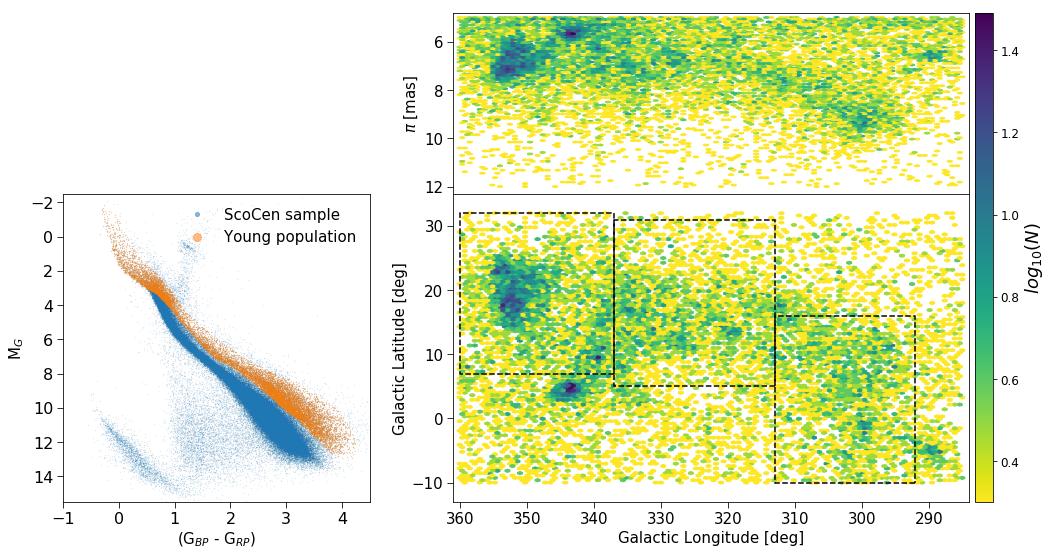

In [9]:
'''Combined figures'''

LCC = patches.Rectangle((292, -10), 21, 26,linewidth = 1.5, linestyle = '--', edgecolor = 'k', facecolor = 'none')
UCL = patches.Rectangle((313,5), 24, 26, linewidth = 1.5,  linestyle ='--', edgecolor = 'k', facecolor = 'none')
US  = patches.Rectangle((337,7), 23, 25, linewidth = 1.5, linestyle = '--', edgecolor = 'k', facecolor = 'none')

fig, ((axA_1, axC),(axA, axB)) = plt.subplots(figsize = (18,9), nrows = 2, ncols = 2, sharey = False,\
                                 gridspec_kw = {'width_ratios':[1, 2], 'height_ratios':[1, 1.7]})

axA.plot(Cleaned_Sample['bp_rp'], Cleaned_Sample['g_mag_abs'], 'o', markersize = 0.1, alpha = 0.5)
axA.plot(Sample_DR2[:,0], Sample_DR2[:,1], 'o', markersize = 0.2, alpha = 0.5)
axA.legend(['ScoCen sample', 'Young population'], \
           frameon = False, prop = {'size': 15}, markerscale = 40, loc = 'upper right')
axA.set_ylim(15.5,-2.5)
axA.set_xlim(-1, 4.5)
axA.set_ylabel(r"M$_{G}$", size = 15)
axA.set_xlabel(r"(G$_{BP}$ - G$_{RP}$)", size = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 16, size = 6)

axA_1.remove()

B = axB.hexbin(l_DR2, b_DR2, gridsize = 100, bins = 'log', mincnt = 1, cmap = 'viridis_r')
axB.add_patch(US)
axB.add_patch(UCL)
axB.add_patch(LCC)
axB.set_xlim(361, 284)
axB.set_ylim(-13, 35)
axB.set_xlabel("Galactic Longitude [deg]", size = 15)
axB.set_ylabel("Galactic Latitude [deg]", size = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15, size = 6)
# cb = fig.colorbar(B, ax = axB, pad = 0.01)
# cb.set_label(r'$log_{10} (N)$', size = 15)

C = axC.hexbin(l_DR2, parallax, gridsize = 100, bins = 'log', mincnt = 1, cmap = 'viridis_r')
axC.set_xlim(361, 284)
axC.set_ylim(12.3,4.8)
axC.set_ylabel(r"$\pi$ [mas]", size = 15)
axC.tick_params(axis = 'y', which = 'major', labelsize = 15, size = 6)
axC.get_xaxis().set_visible(False)
# cb = fig.colorbar(C, ax = axC, pad = 0.01)
# cb.set_label(r'$log_{10} (N)$', size = 15)

axC.get_shared_x_axes().join(axB, axC)

fig.subplots_adjust(wspace = 0.18)
fig.subplots_adjust(hspace = 0.00)
cb = fig.colorbar(C, ax = (axB,axC), pad = 0.01, aspect = 27)
cb.set_label(r'$log_{10} (N)$', size = 18)
cb.ax.set_yticklabels(['0.4', '0.6', '0.8', '1.0', '1.2', '1.4'], fontsize = 12)

plt.savefig("./Figures/ScoCen_Coordinates.png", dpi = 300, bbox_inches = 'tight')

In [7]:
'''Ra and Dec coordinates are saved for the selected pre-main sequence sample'''

print('There are %i pre-main sequence stars in the sample'%len(RA_DR2))

RA = np.append(RA_DR2, RA_DR2); DEC = np.append(DEC_DR2, DEC_DR2)
l = np.append(l_DR2, l_DR2); b = np.append(b_DR2, b_DR2)

np.savetxt('./Data/Coordinates_DR2_PreMainSequence.csv',\
           np.c_[RA, DEC, l, b], header = 'ra, dec, l, b',\
           fmt = ['%.15f','%.15f', '%.15f','%.15f'], delimiter = ',')


There are 14343 pre-main sequence stars in the sample
